# Notebook 50: Single HR panel for one mass and all periods

In [2]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 50

## Imports

In [3]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr)

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [4]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

In [5]:

FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [6]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [7]:
Z_SUN = 0.017

### Utilities

In [8]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [9]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [10]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [11]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [12]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


In [13]:
mesareader_operator('log_L/Estar_mass,^log_L,surface_h1)')

'h.__getattr__("log_L")/gamma_e(h.__getattr__("star_mass"),10**h.__getattr__("log_L"),h.__getattr__("surface_h1"))'

### Plotting

In [14]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax

### Winds

In [15]:
def _sanders_winds(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1.41e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/Z_SUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [16]:
vink2001_w = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [17]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, t, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [18]:
winds = np.vectorize(_winds)

## HR diagram

In [19]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [20]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [21]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

In [22]:
def density_temperature_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_center_Rho',
        y='log_center_T',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log \\rho_\\mathrm{c}/\\mathrm{g}\\,\\mathrm{cm}^{-3}$')
    if labely:
        ax.set_ylabel('$\\log T_\\mathrm{c}/\\mathrm{K}$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

In [23]:
def old_e_scattering_edd_l(m):
    m = fix_unit(m, u.Msun)
    k = 0.4 * u.cm**2 /u.g
    l = 4*np.pi*ct.c*ct.G*m/k
    l = l.to(u.Lsun)
    return l.value

In [24]:
def gamma_e(m, l, x):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 10.**-4.813 * (1+x) * l/m

In [25]:
def compas_gamma_e(m, l):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 7.66e-5 * 0.325*l/m

In [71]:
def hre_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        #y='^log_L/Estar_mass)',
        y='Estar_mass,^log_L,surface_h1)',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\Gamma_\mathrm{e}$')
    
    if xlim is not None:    
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    return ax

### Final properties

In [27]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

In [28]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

In [29]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

def bjorklund2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

def sander2023_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1e5)
        w = 10.**log_w
    return w

def get_g_switch(l, m, t, z, x, scheme):
    z_div_zsun = z/Z_SUN
    if scheme == 'vink':
        g_switch = 0.243 * z_div_zsun**-0.541
    elif scheme == 'krticka':
        g_switch = 0.585 * z_div_zsun**-0.016
    elif scheme == 'bjorklund':
        g_switch = 0.838 * z_div_zsun**-0.099
    elif scheme == 'bjorklund+krticka':
        k24_w = krticka2024_w(l, t, z)
        b23_w = bjorklund2023_w(l, m, t, z, x)
        if k24_w <= b23_w:
            g_switch = 0.585 * z_div_zsun**-0.016
        else:
            g_switch = 0.838 * z_div_zsun**-0.099
    return g_switch

def vink2011_winds(l, m, t, z, x, g_switch, m_switch):
    g_e = edd_gamma(x, l, m)
    v01_w = vink2001_w(l, t, m, z)
    
    if g_e < g_switch:
        w = v01_w
    else:
        w = v01_w * (m/m_switch)**0.78 * (g_e/g_switch)**4.77
        
    return w
        

class Winds:
    
    def __init__(self, ms_winds):
        self.ms_winds = ms_winds
        self.g_switch = None
        self.m_switch = 10
        self.vms_switch = False
        
    def winds(self, l, m, teff, z, x, ms_winds):
        x0 = 0.6
        dx = 0.3
        
        #MS or WR winds
        if x > x0:
            he_poor_a = 1
        elif x > x0-dx:
            he_poor_a = (x - (x0-dx)) / dx
        else:
            he_poor_a = 0
        
            
        vink2001_winds = vink2001_w(l, teff, m, z)
        bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
        krticka2024_winds = krticka2024_w(l, teff, z)
        vink2017_winds = vink2017_w(l, z)
        sander2023_winds = sander2023_w(l, teff, z)
        
        if ms_winds == 'vink':
            ms_w = vink2001_winds
        elif ms_winds == 'bjorklund':
            ms_w = bjorklund2023_winds
        elif ms_winds == 'krticka':
            ms_w = krticka2024_winds
        elif ms_winds == 'bjorklund+krticka':
            ms_w = min(bjorklund2023_winds, krticka2024_winds)
        else:
            raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
        
        if self.g_switch is None:
            g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
        else:
            g_switch = self.g_switch
        g_e = edd_gamma(x, l, m)
        
        if (g_e >= g_switch) and (self.vms_switch is False):
            self.vms_switch = True
            self.m_switch = m
            self.g_switch = g_switch
            
        vms_w = vink2011_winds(l, m, teff, z, x, g_switch, self.m_switch)
        
        if g_e > g_switch:
            ms_w = vms_w        
        
        w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
        return w
    
    
def winds(l, m, teff, z, x, ms_winds='vink'):
    x0 = 0.6
    dx = 0.3
       
    #MS or WR winds
    if x > x0:
        he_poor_a = 1
    elif x > x0-dx:
        he_poor_a = (x - (x0-dx)) / dx
    else:
        he_poor_a = 0
    
        
    vink2001_winds = vink2001_w(l, teff, m, z)
    bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
    krticka2024_winds = krticka2024_w(l, teff, z)
    vink2017_winds = vink2017_w(l, z)
    sander2023_winds = sander2023_w(l, teff, z)
    
    if ms_winds == 'vink':
        ms_w = vink2001_winds
    elif ms_winds == 'bjorklund':
        ms_w = bjorklund2023_winds
    elif ms_winds == 'krticka':
        ms_w = krticka2024_winds
    elif ms_winds == 'bjorklund+krticka':
        ms_w = min(bjorklund2023_winds, krticka2024_winds)
    else:
        raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
    
    g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
    
    
    w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
    return w
    

# Analysis

As a benchmark, we run a model using Vink (2001) MS winds and Vink et al. (2011) VMS winds with a $\Gamma_\mathrm{switch}$ following from Sabhahit. This model uses the de Boer et al. (2017) $^{12}\mathrm{C}(\alpha,\gamma)^{16}\mathrm{O}$ rates with updates by Mehta et al. (2022). 

In [30]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/90msun_test5_vink'

model_ids = [1]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/90msun_test5_vink/001_md1_m90_zsundiv10_04y0_03dy


In [31]:
model_dicts1 = model_dicts

Text(0.5, 1.0, '$90.0\\,\\mathrm{M}_\\odot$')

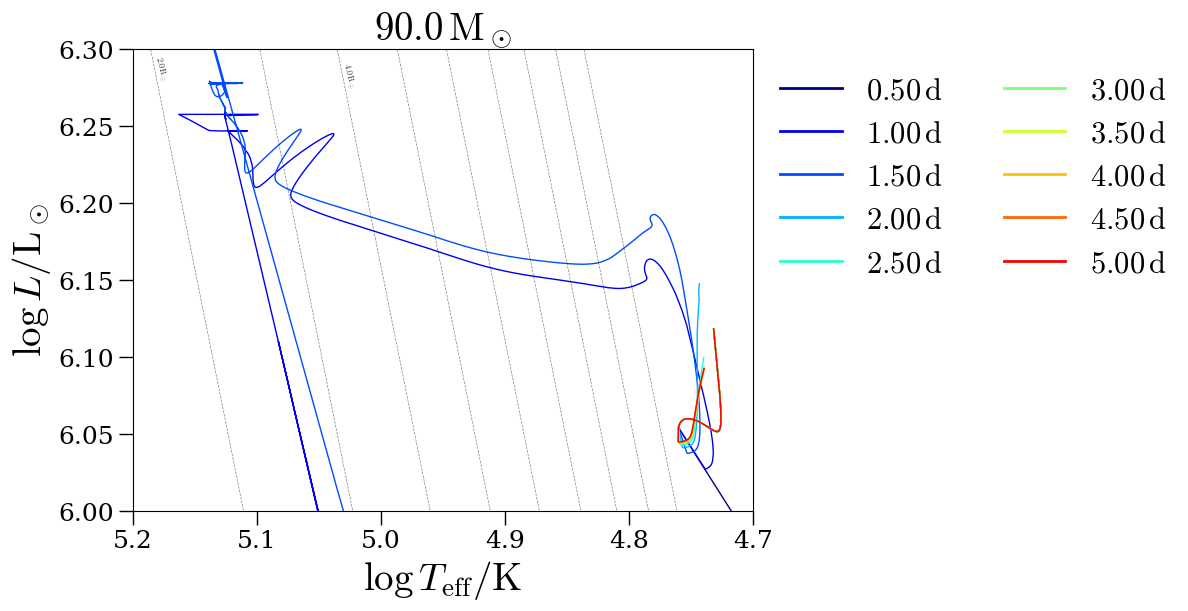

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
test_m = '90.0'

models_to_plot = [0]
model_style_list = ['-']
xlim = (5.2, 4.7)
ylim = (6, 6.3)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=[0],
    model_style_list=['-'],
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

Although our models successfully get past core He burning (onset marked by the hook feature), they now fail at a later stage. Let us look at the $1.00\,\mathrm{d}$ case closely to determine the issue.

In [33]:
wind_test_h = mr.MesaData(str(model_dicts[0]['90.0']['1.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]
wind_test_omega = wind_test_omega[wind_test_start_i:]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b23_winds = np.array([
    bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
v01_winds = np.array([
    vink2001_w(l, t, m, z) for l, t, m, z in zip(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, ms_winds='vink') for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]

mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
    

From a look at the wind diagram, we can promptly rule out an issue with the wind models. MESA is following the assigned prescriptions precisely, with the star transitioning from He-poor to He-rich winds already in the thick regime (for He-rich winds). At this metallicity ($0.1\,\mathrm{Z}_\odot$), He-poor winds only become thick for $\Gamma_\mathrm{e}\gtrsim0.7$.

/tmp/ipykernel_2449667/2139300354.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='S23', lw=1)
/tmp/ipykernel_2449667/2139300354.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


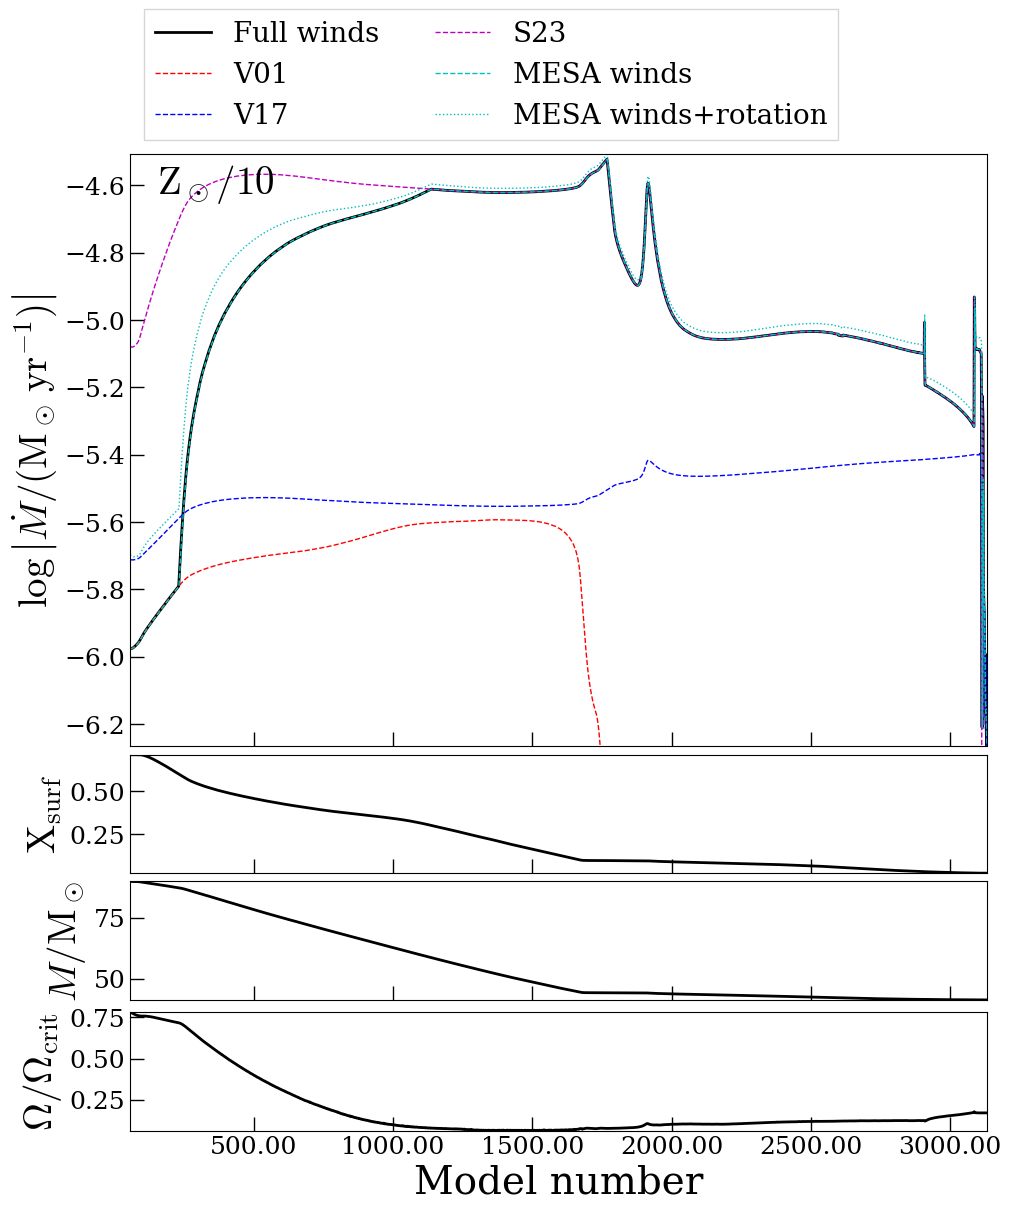

In [34]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_model_n
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
#ax0.plot(x, np.log10(k24_winds), 'g--', label='K24', lw=1)
#ax0.plot(x, np.log10(b23_winds), 'r--', label='B23', lw=1)
ax0.plot(x, np.log10(v01_winds), 'r--', label='V01', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='V17', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='S23', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('Model number')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'windiag_m40_p060_zsun_div_10')

Text(0, 0.5, '$\\Gamma_\\mathrm{e}$')

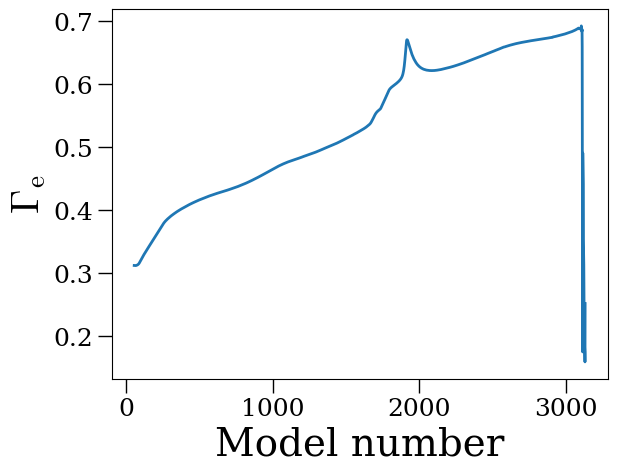

In [35]:
plt.plot(wind_test_model_n, wind_test_g)
plt.xlabel('Model number')
plt.ylabel('$\Gamma_\mathrm{e}$')

The jittering above model 3000 thus comes from the model crashing due to a different reason. We can check that this is happening during C burning.

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

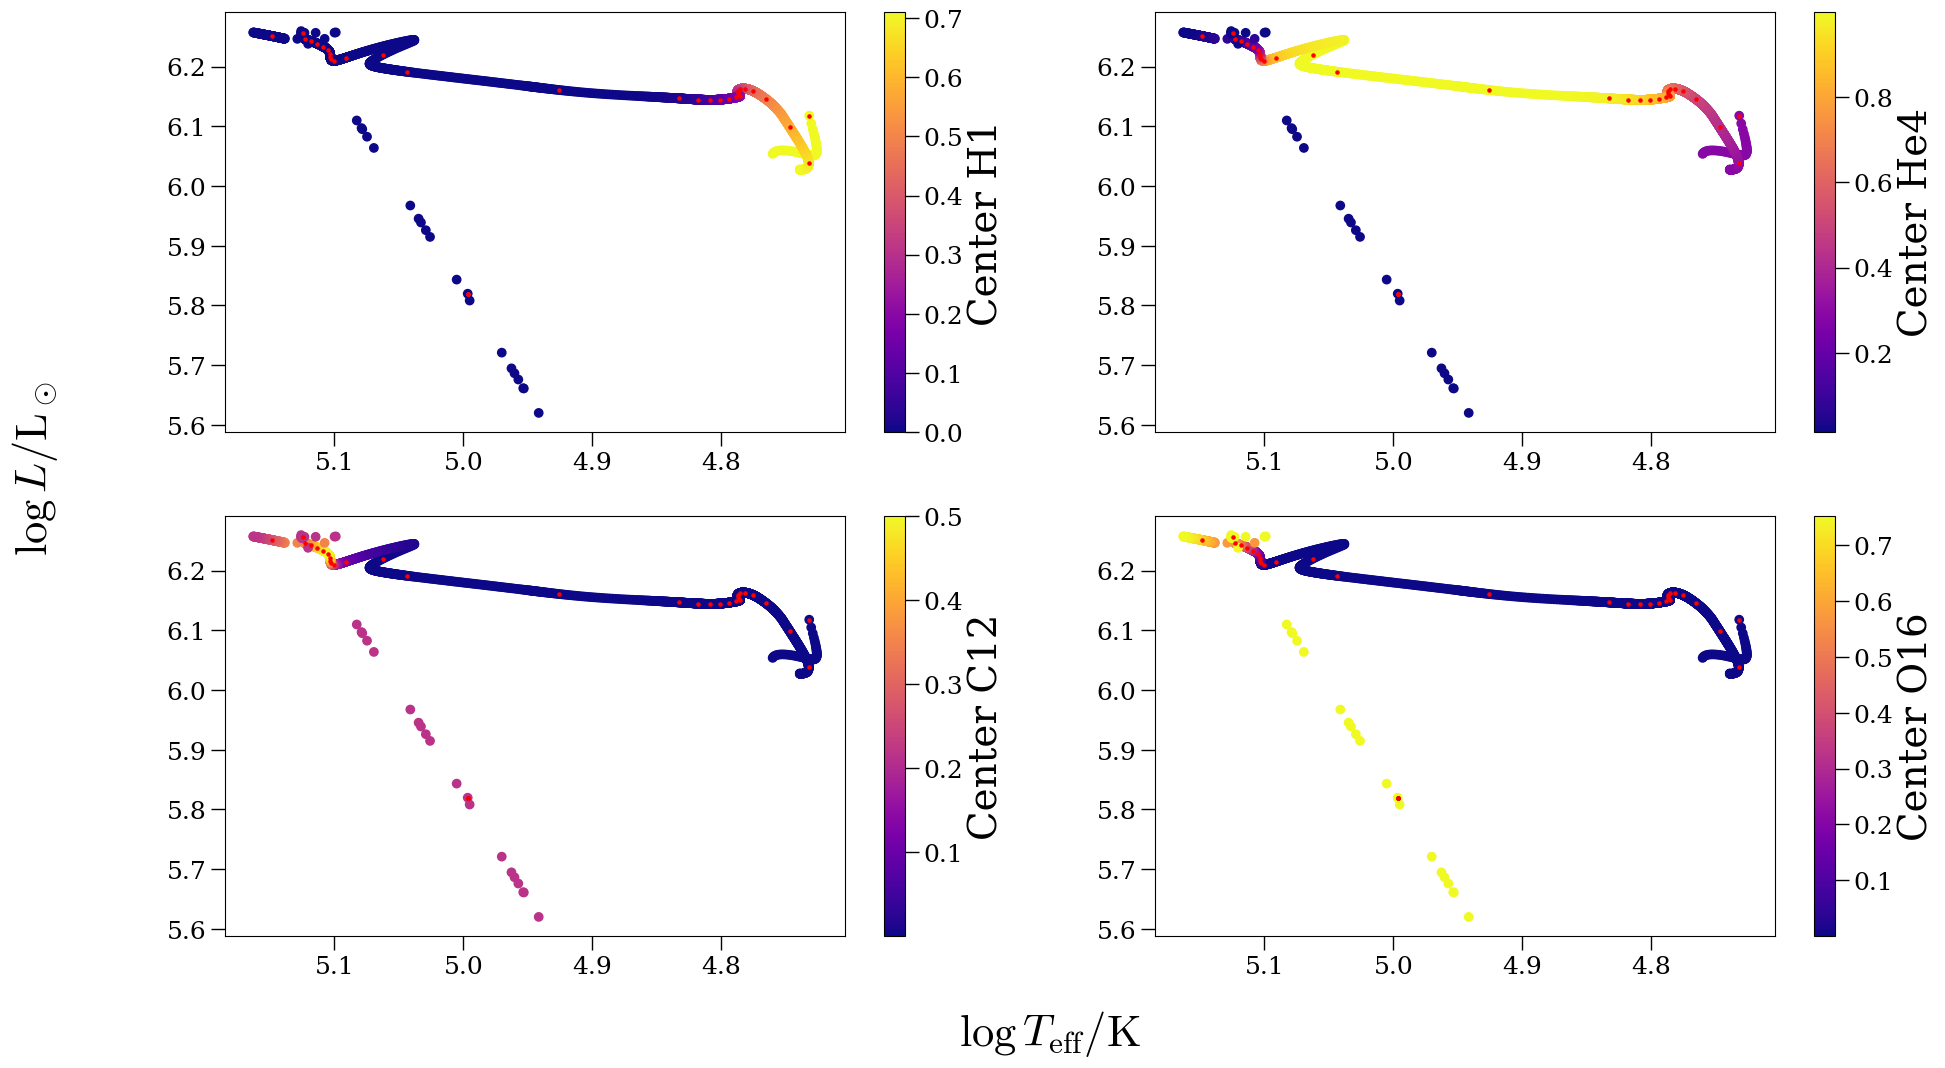

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
# one red dot every 50 kyr
#models_to_mark = np.arange(min(h.star_age), max(h.star_age), 1e4)
#model_numbers = h.star_age

# one red dot every 100 models
models_to_mark = np.arange(0, 4000, 100)
model_numbers = h.model_number

modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

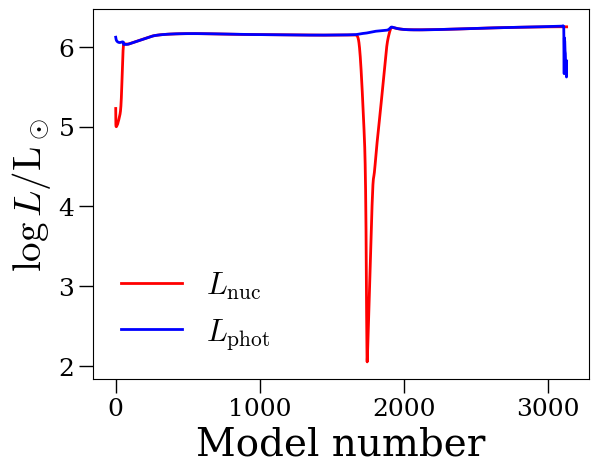

In [37]:
plt.plot(wind_test_h.model_number, wind_test_h.log_Lnuc, 'r-', label='$L_\mathrm{nuc}$')
plt.plot(wind_test_h.model_number, wind_test_h.log_L, 'b-', label='$L_\mathrm{phot}$')
#plt.xlim(3070)
plt.xlabel('Model number')
plt.ylabel('$\log L/\mathrm{L}_\odot$')
plt.legend(frameon=False)

Since this model had succesfully run through C burning with Vink (2001) winds before, the obvious candidate for the culprit are the new de Boer et al. (2017) rates; the previous model having been run with the Kunz et al. (2002) rates. The lower $\alpha$-capture on to carbon rates from de Boer et al. (2017) lead to a larger C/O fraction and more intense C burning, which is possibly unstable under the MESA settings originally optimized for the Kunz et al. (2012) rates in a $40\,\mathrm{M}_\odot$ star. We thus restart this run from model 2000 (shortly after core He ignition; see plot above) with the Kunz et al. (2002) rates and check if it improves stability.

In [38]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/90msun_test5_vink_kunz'

model_ids = [1]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/90msun_test5_vink_kunz/001_md1_m90_zsundiv10_04y0_03dy


In [39]:
model_dicts2 = model_dicts

In [40]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/90msun_test5_vink_kunz'

model_ids = [2]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/90msun_test5_vink_kunz/002_FULLRESTART_md1_m90_zsundiv10_04y0_03dy


In [41]:
model_dicts3 = model_dicts

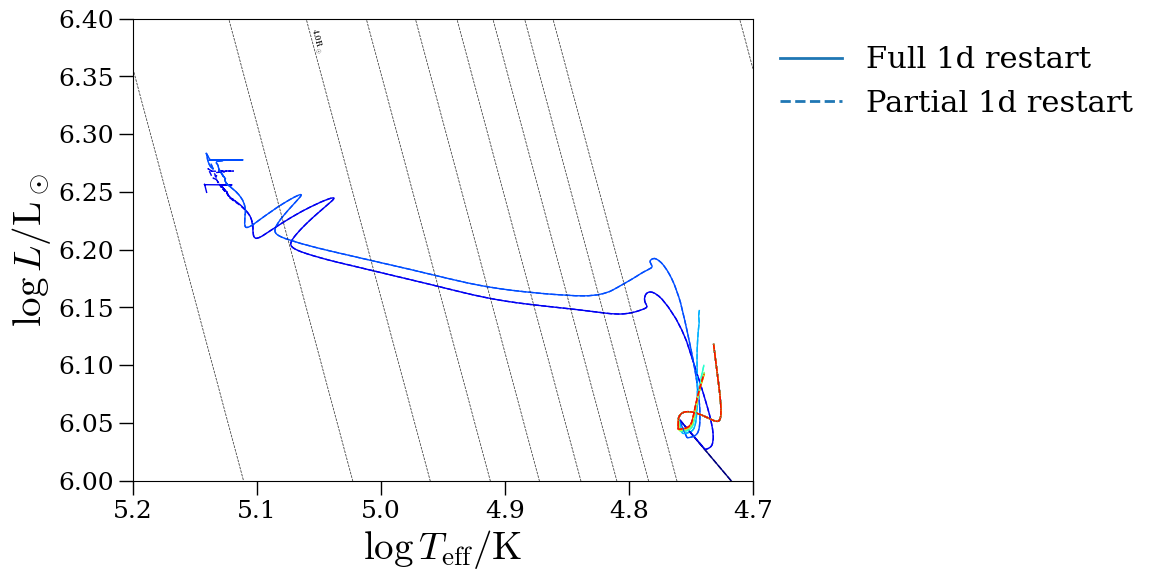

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
test_m = '90.0'

model_dicts = model_dicts3
models_to_plot = [0]
model_style_list = ['-']
xlim = (5.2, 4.7)
ylim = (6, 6.4)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list ,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

model_dicts = model_dicts2
models_to_plot = [0]
model_style_list = ['--']
xlim = (5.2, 4.7)
ylim = (6, 6.4)
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list ,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], ls='-', label='Full 1d restart'))
handles.append(Line2D([], [], ls='--', label='Partial 1d restart'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

In [43]:
model_dicts[0]['90.0']['1.00']/'LOGS/history.data'

PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/90msun_test5_vink_kunz/001_md1_m90_zsundiv10_04y0_03dy/m9.000d+01_p1.000d+00_w7.272d-05/LOGS/history.data')

In [44]:
wind_test_h = mr.MesaData(str(model_dicts[0]['90.0']['1.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]
wind_test_omega = wind_test_omega[wind_test_start_i:]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b23_winds = np.array([
    bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
v01_winds = np.array([
    vink2001_w(l, t, m, z) for l, t, m, z in zip(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, ms_winds='vink') for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]

mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
    

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

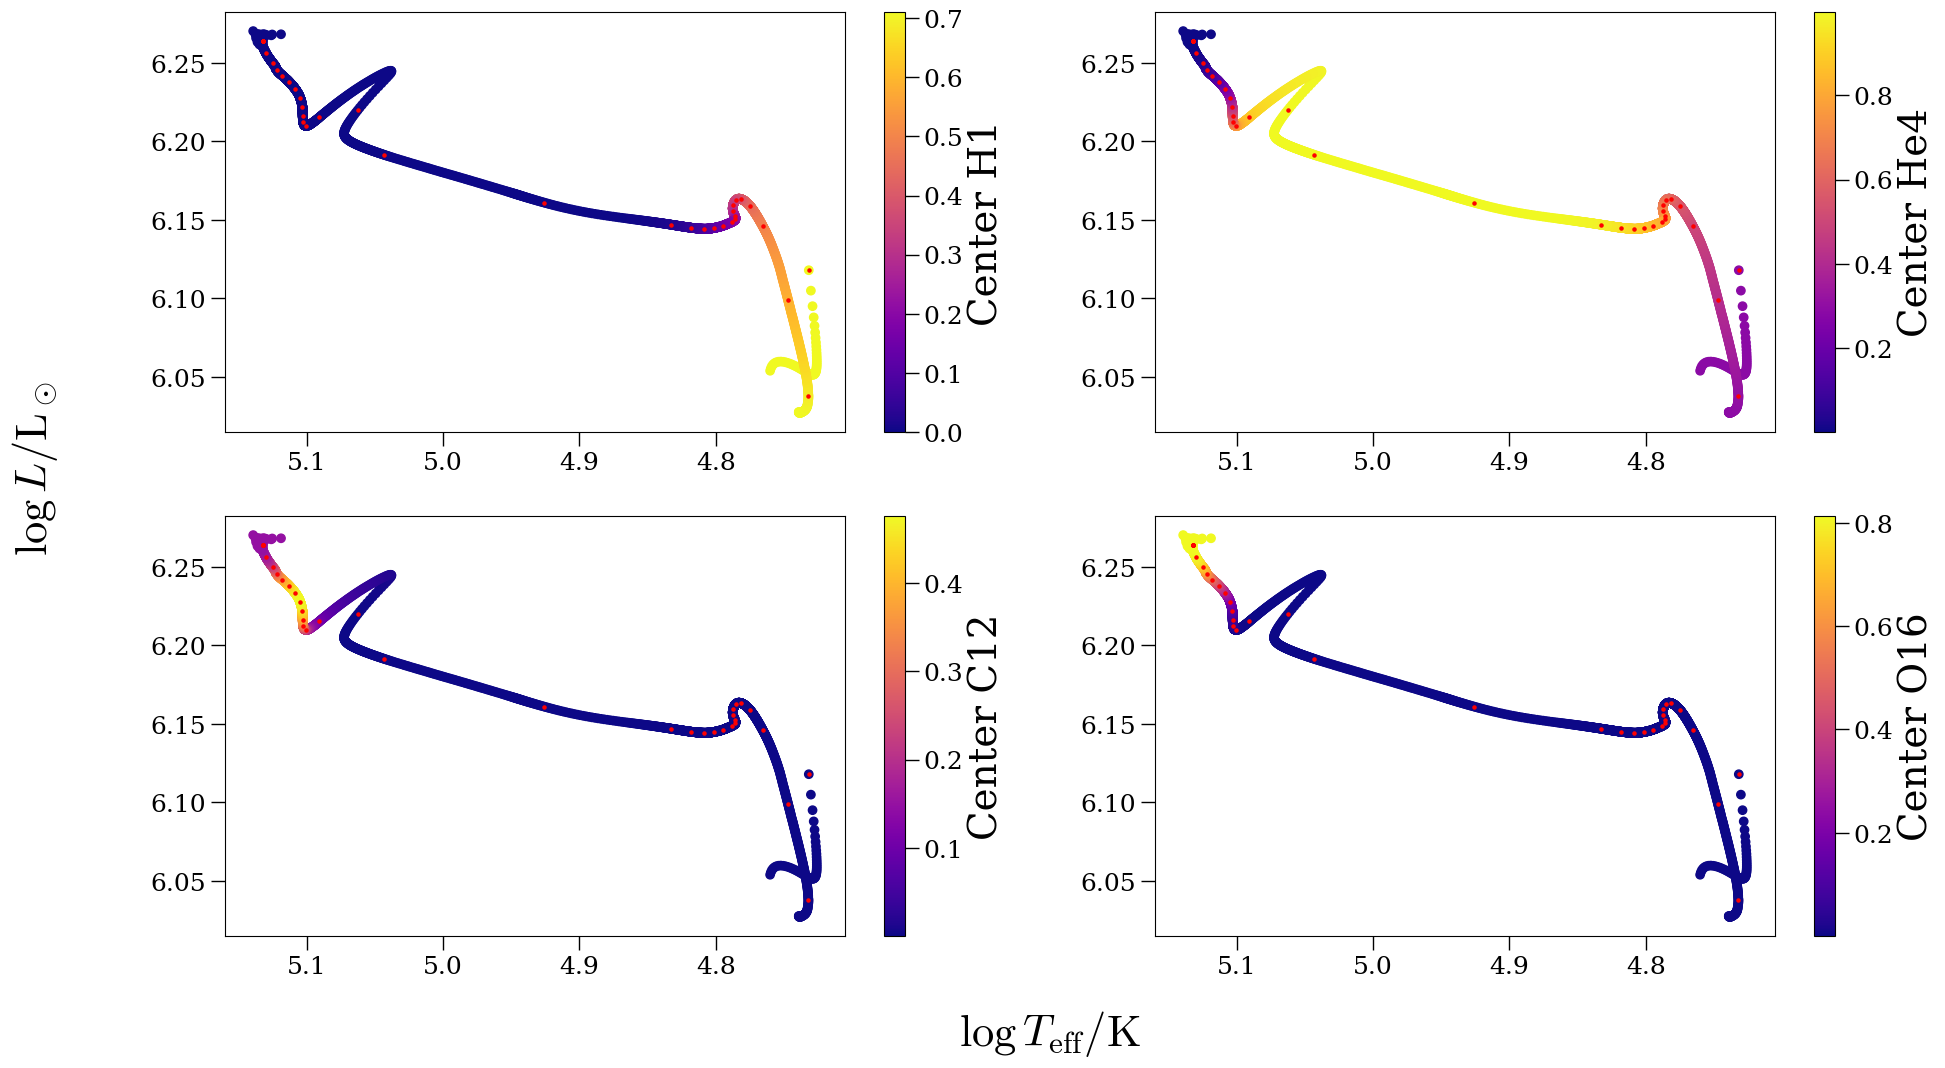

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
# one red dot every 50 kyr
#models_to_mark = np.arange(min(h.star_age), max(h.star_age), 1e5)
#model_numbers = h.star_age

# one red dot every 100 models
models_to_mark = np.arange(0, 4000, 100)
model_numbers = h.model_number

modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

Text(0, 0.5, '$\\Gamma_\\mathrm{e}$')

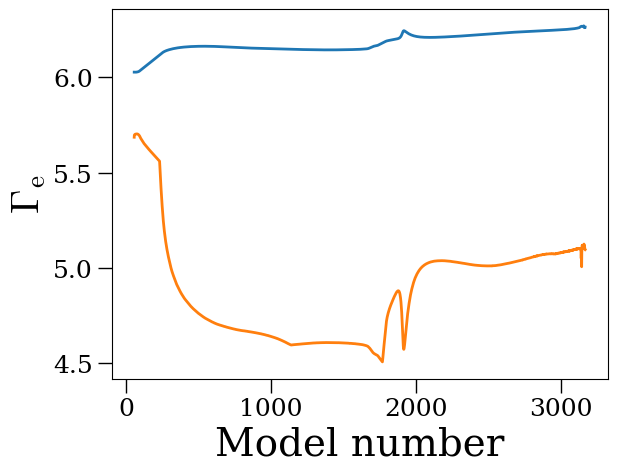

In [46]:
plt.plot(wind_test_model_n, np.log10(wind_test_l))
plt.plot(wind_test_model_n, -1*mesa_wind_rot)
plt.xlabel('Model number')
plt.ylabel('$\Gamma_\mathrm{e}$')

#### Other test grids

In [47]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/300msun_test3'

model_ids = [1]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/300msun_test3/001_md1_m300_zsundiv10_04y0_03dy


Model /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/300msun_test3/001_md1_m300_zsundiv10_04y0_03dy/m3.000d+02_p3.500d+00_w2.078d-05 failed to load.


Text(0.5, 1.0, '$300.0\\,\\mathrm{M}_\\odot$')

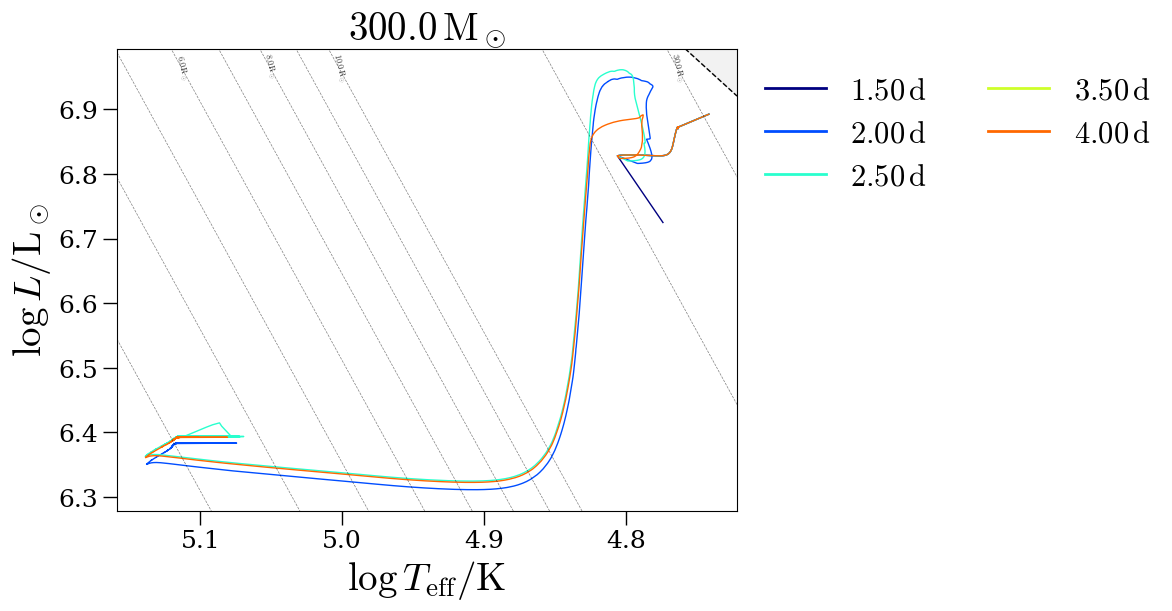

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
test_m = '300.0'

models_to_plot = [0]
model_style_list = ['-']
xlim = None
ylim = None
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list ,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )


ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')


In [49]:
wind_test_h = mr.MesaData(str(model_dicts[0]['300.0']['2.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]
wind_test_omega = wind_test_omega[wind_test_start_i:]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b23_winds = np.array([
    bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
v01_winds = np.array([
    vink2001_w(l, t, m, z) for l, t, m, z in zip(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
])

fw = Winds(ms_winds='bjorklund+krticka')

full_winds = np.array([
    fw.winds(l, m, t, z, x, ms_winds='bjorklund+krticka') for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]

mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
    

/tmp/ipykernel_2449667/858475602.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


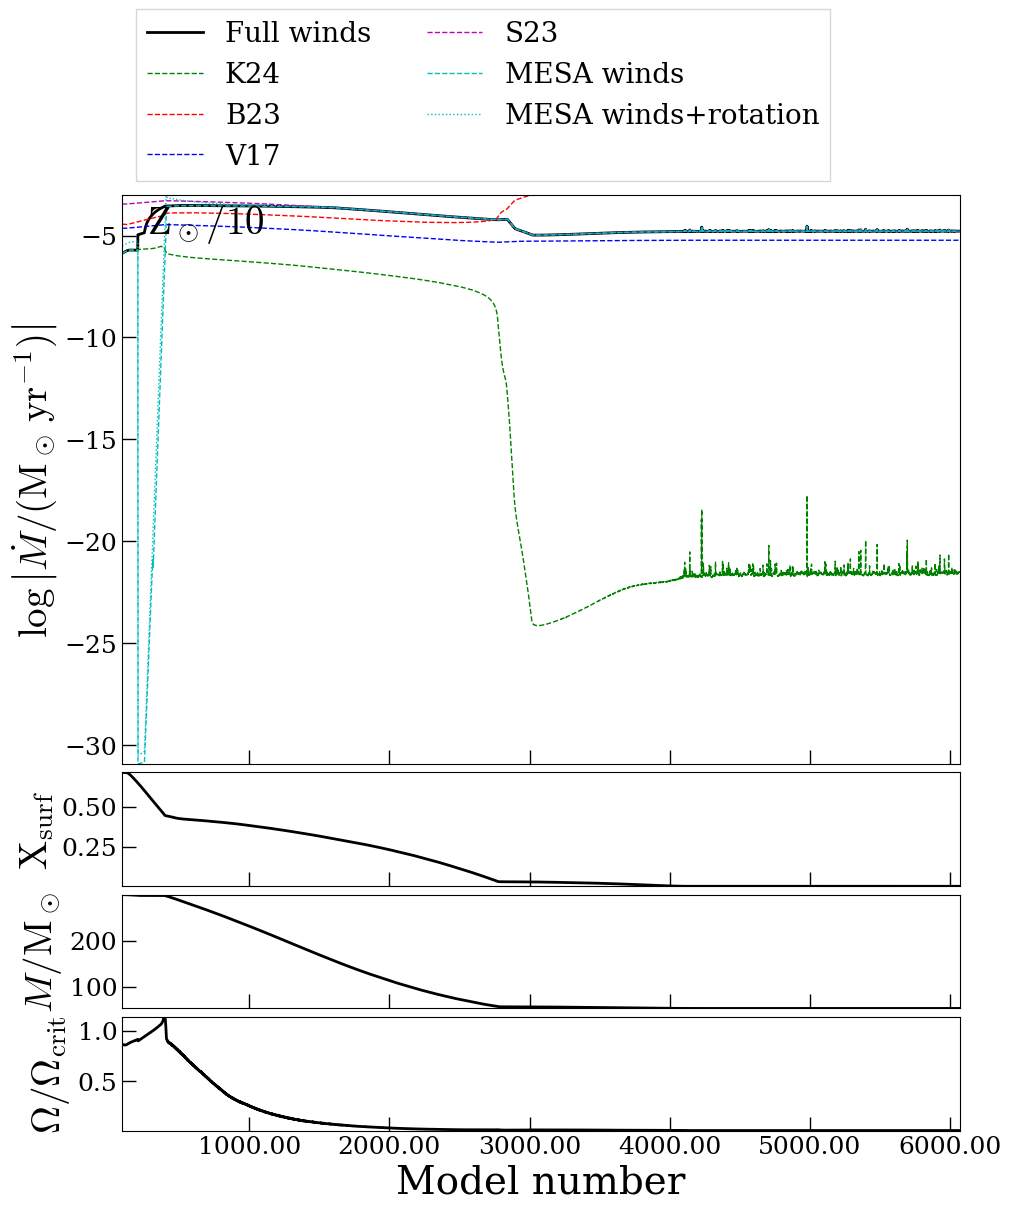

In [51]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_model_n
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(k24_winds), 'g--', label='K24', lw=1)
ax0.plot(x, np.log10(b23_winds), 'r--', label='B23', lw=1)
#ax0.plot(x, np.log10(v01_winds), 'r--', label='V01', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='V17', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='S23', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('Model number')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'windiag_m40_p060_zsun_div_10')

Text(0, 0.5, '$\\Gamma_\\mathrm{e}$')

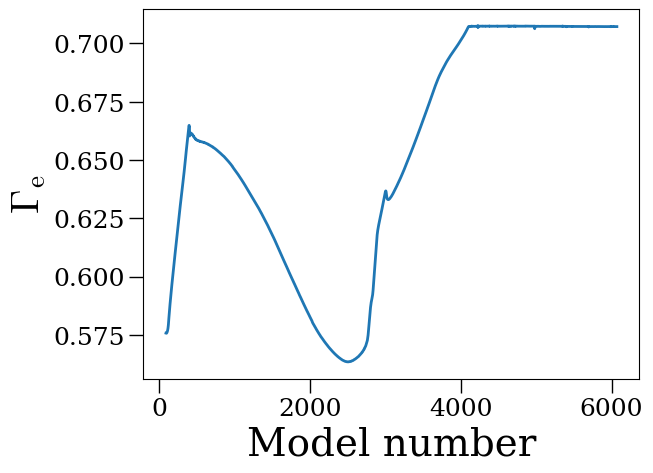

In [52]:
plt.plot(wind_test_model_n, wind_test_g)
plt.xlabel('Model number')
plt.ylabel('$\Gamma_\mathrm{e}$')

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

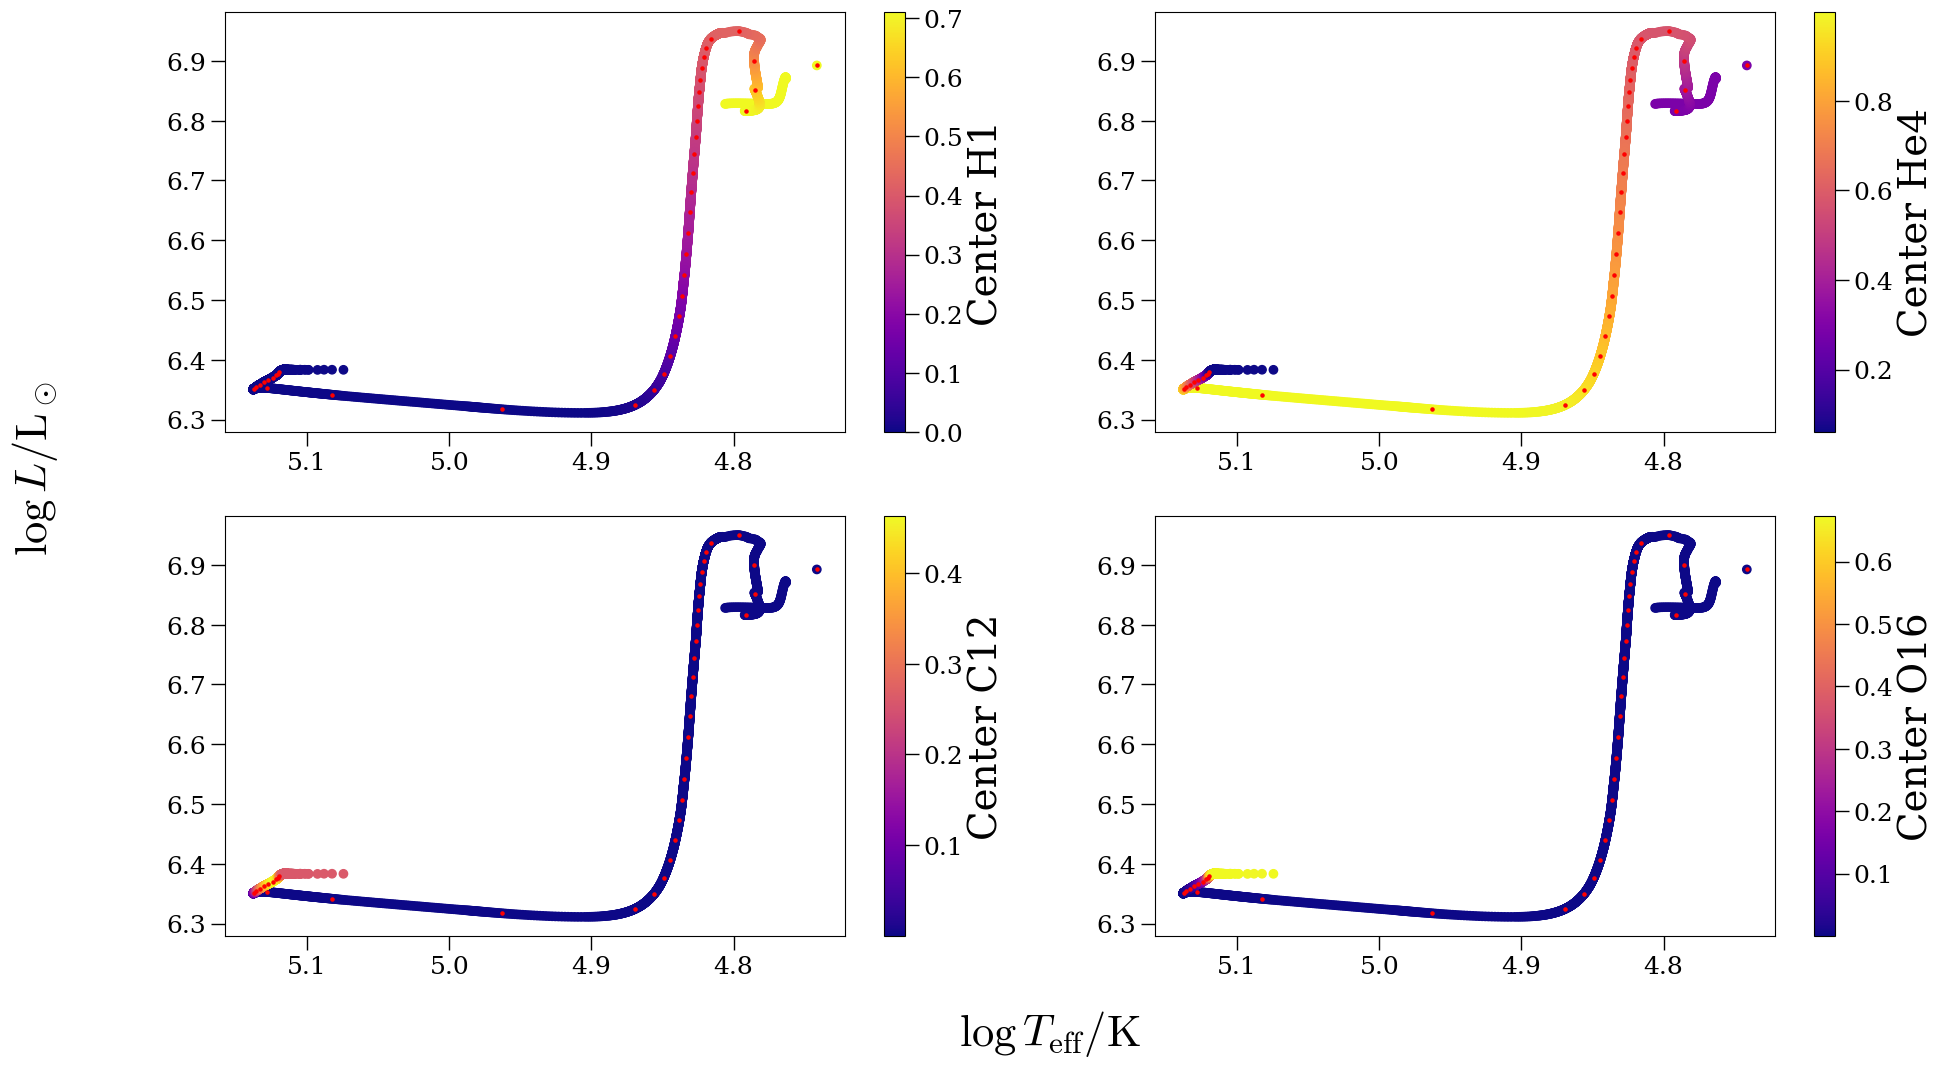

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
# one red dot every 50 kyr
#models_to_mark = np.arange(min(h.star_age), max(h.star_age), 1e5)
#model_numbers = h.star_age

# one red dot every 100 models
models_to_mark = np.arange(0, 4000, 100)
model_numbers = h.model_number

modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

In [54]:
wind_test_h = mr.MesaData('/mnt/home/ldesa/ceph/mesa_che_grids/sse_carbon/020_md1_m300_zsundiv10_04y0_03dy/m3.000d+02_w3.636d-05/LOGS/history.data')

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]
wind_test_omega = wind_test_omega[wind_test_start_i:]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b23_winds = np.array([
    bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
v01_winds = np.array([
    vink2001_w(l, t, m, z) for l, t, m, z in zip(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
])

fw = Winds(ms_winds='bjorklund+krticka')

full_winds = np.array([
    fw.winds(l, m, t, z, x, ms_winds='bjorklund+krticka') for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]

mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
    

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

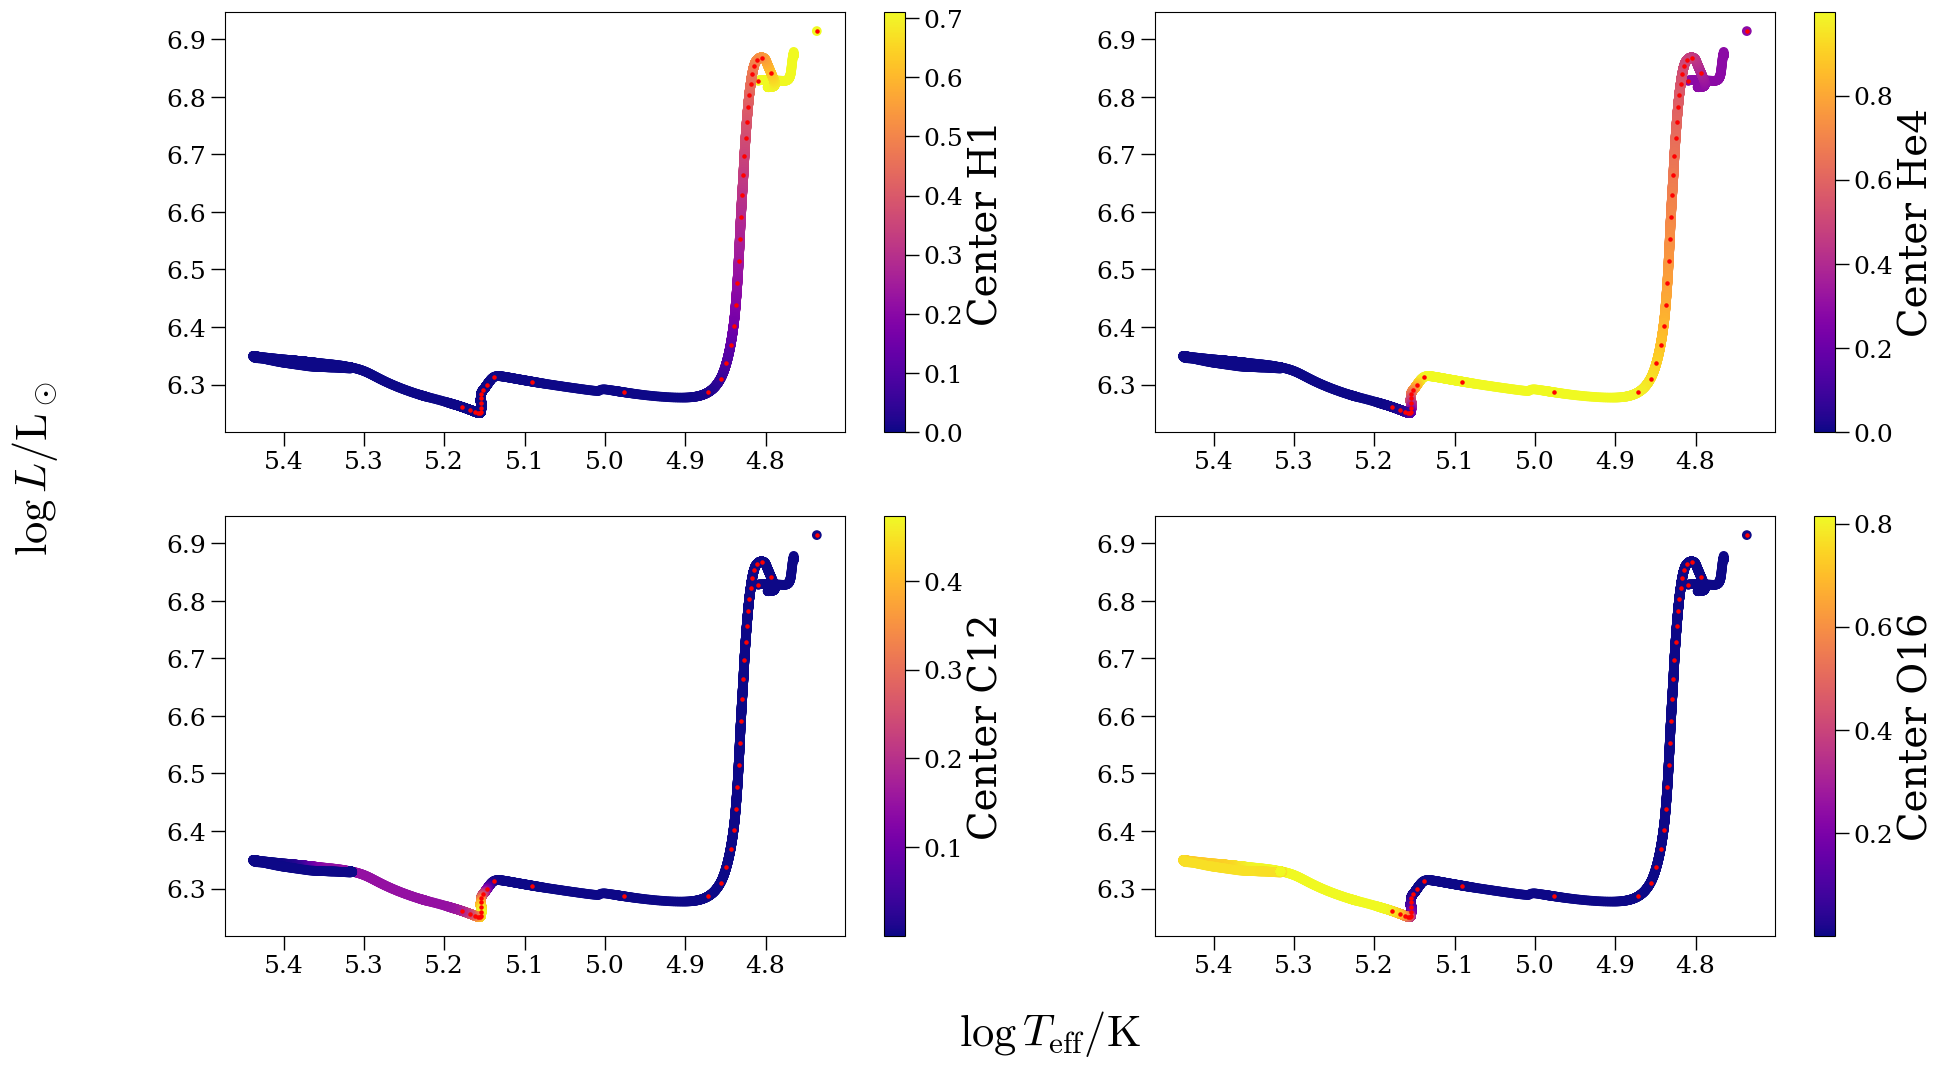

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
# one red dot every 50 kyr
#models_to_mark = np.arange(min(h.star_age), max(h.star_age), 1e5)
#model_numbers = h.star_age

# one red dot every 100 models
models_to_mark = np.arange(0, 4000, 100)
model_numbers = h.model_number

modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)
    

### Old run comparison

In [56]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/90msun_test6_oldgrid_kunz'

model_ids = [1]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/90msun_test6_oldgrid_kunz/001


In [57]:
test6_kunz_model_dicts = model_dicts

In [58]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/90msun_test6_oldgrid_deboer'

model_ids = [1]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/90msun_test6_oldgrid_deboer/001


In [59]:
test6_deboer_model_dicts = model_dicts

In [60]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/90msun_test7_oldgrid_kunz_sanderTcorr'

model_ids = [1]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/90msun_test7_oldgrid_kunz_sanderTcorr/001


In [61]:
test7_kunz_model_dicts = model_dicts

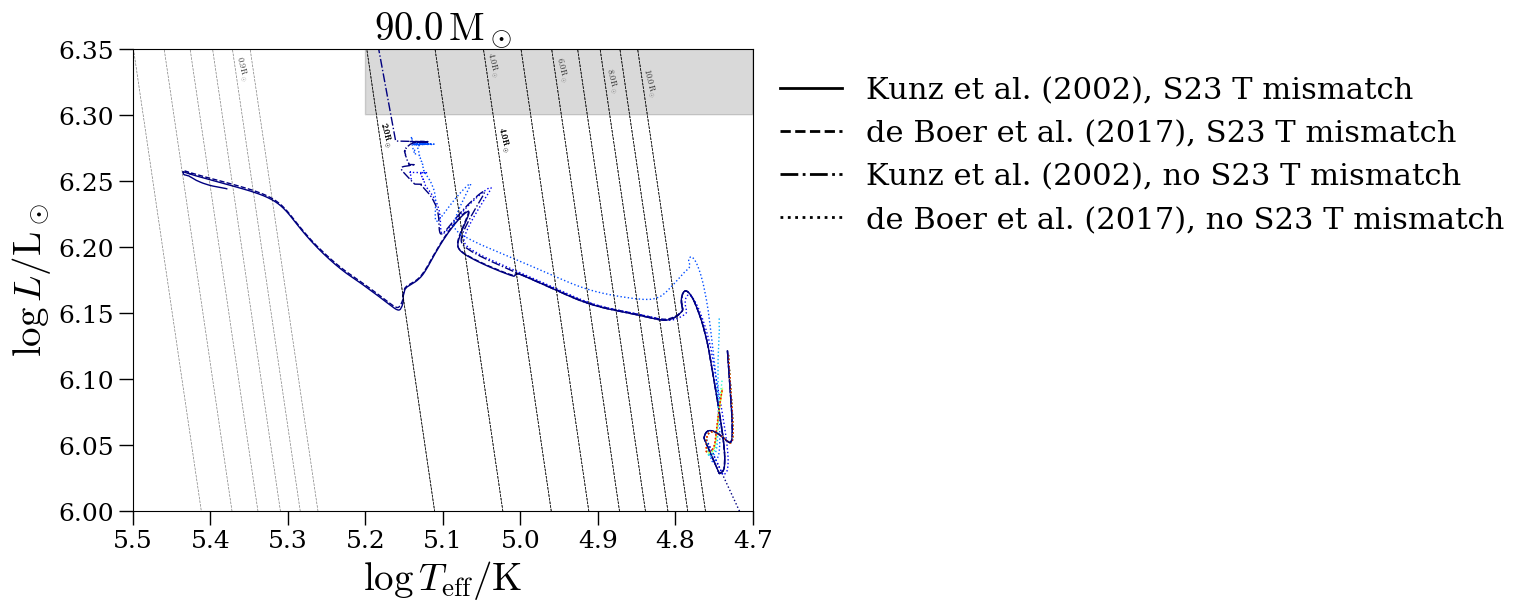

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
test_m = '90.0'

model_dicts = test6_kunz_model_dicts
models_to_plot = [0]
model_style_list = ['-']
xlim = (5.2, 4.7)
ylim = (6, 6.3)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

model_dicts = test6_deboer_model_dicts
models_to_plot = [0]
model_style_list = ['--']
xlim = (5.2, 4.7)
ylim = (6, 6.3)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

model_dicts = model_dicts3
models_to_plot = [0]
model_style_list = [':']
xlim = (5.2, 4.7)
ylim = (6, 6.3)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

model_dicts = test7_kunz_model_dicts
models_to_plot = [0]
model_style_list = ['-.']
xlim = (5.5, 4.7)
ylim = (6, 6.35)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='k', ls='-', label='Kunz et al. (2002), S23 T mismatch'))
handles.append(Line2D([], [], c='k', ls='--', label='de Boer et al. (2017), S23 T mismatch'))
handles.append(Line2D([], [], c='k', ls='-.', label='Kunz et al. (2002), no S23 T mismatch'))
handles.append(Line2D([], [], c='k', ls=':', label='de Boer et al. (2017), no S23 T mismatch'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

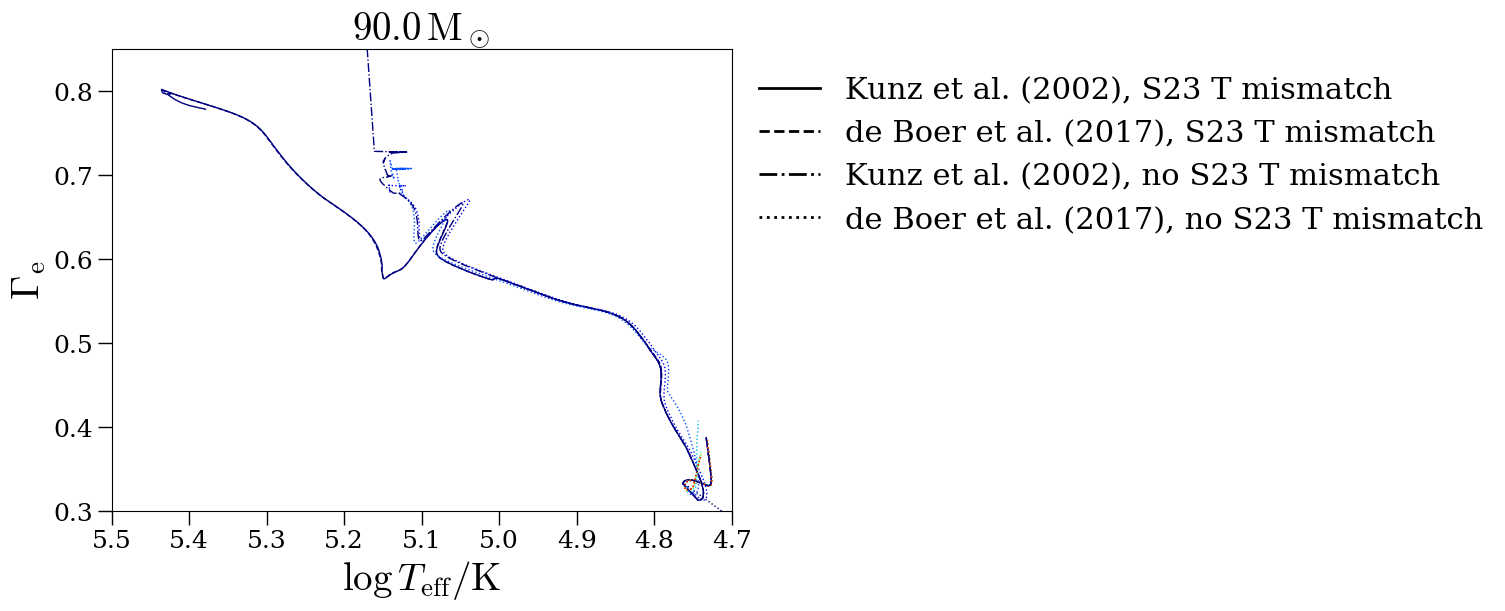

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))
test_m = '90.0'

model_dicts = test6_kunz_model_dicts
models_to_plot = [0]
model_style_list = ['-']
xlim = (5.5, 4.7)
ylim = (0.3, 0.85)
legend = True
labelx = True
labely = True

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

model_dicts = test6_deboer_model_dicts
models_to_plot = [0]
model_style_list = ['--']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

model_dicts = model_dicts3
models_to_plot = [0]
model_style_list = [':']

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

model_dicts = test7_kunz_model_dicts
models_to_plot = [0]
model_style_list = ['-.']

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='k', ls='-', label='Kunz et al. (2002), S23 T mismatch'))
handles.append(Line2D([], [], c='k', ls='--', label='de Boer et al. (2017), S23 T mismatch'))
handles.append(Line2D([], [], c='k', ls='-.', label='Kunz et al. (2002), no S23 T mismatch'))
handles.append(Line2D([], [], c='k', ls=':', label='de Boer et al. (2017), no S23 T mismatch'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

In [69]:
wind_test_h = mr.MesaData(str(test6_kunz_model_dicts[0]['90.0'][1.0000282201104291]/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]
wind_test_omega = wind_test_omega[wind_test_start_i:]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b23_winds = np.array([
    bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
v01_winds = np.array([
    vink2001_w(l, t, m, z) for l, t, m, z in zip(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, ms_winds='vink') for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]

mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
    

/tmp/ipykernel_2449667/2139300354.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


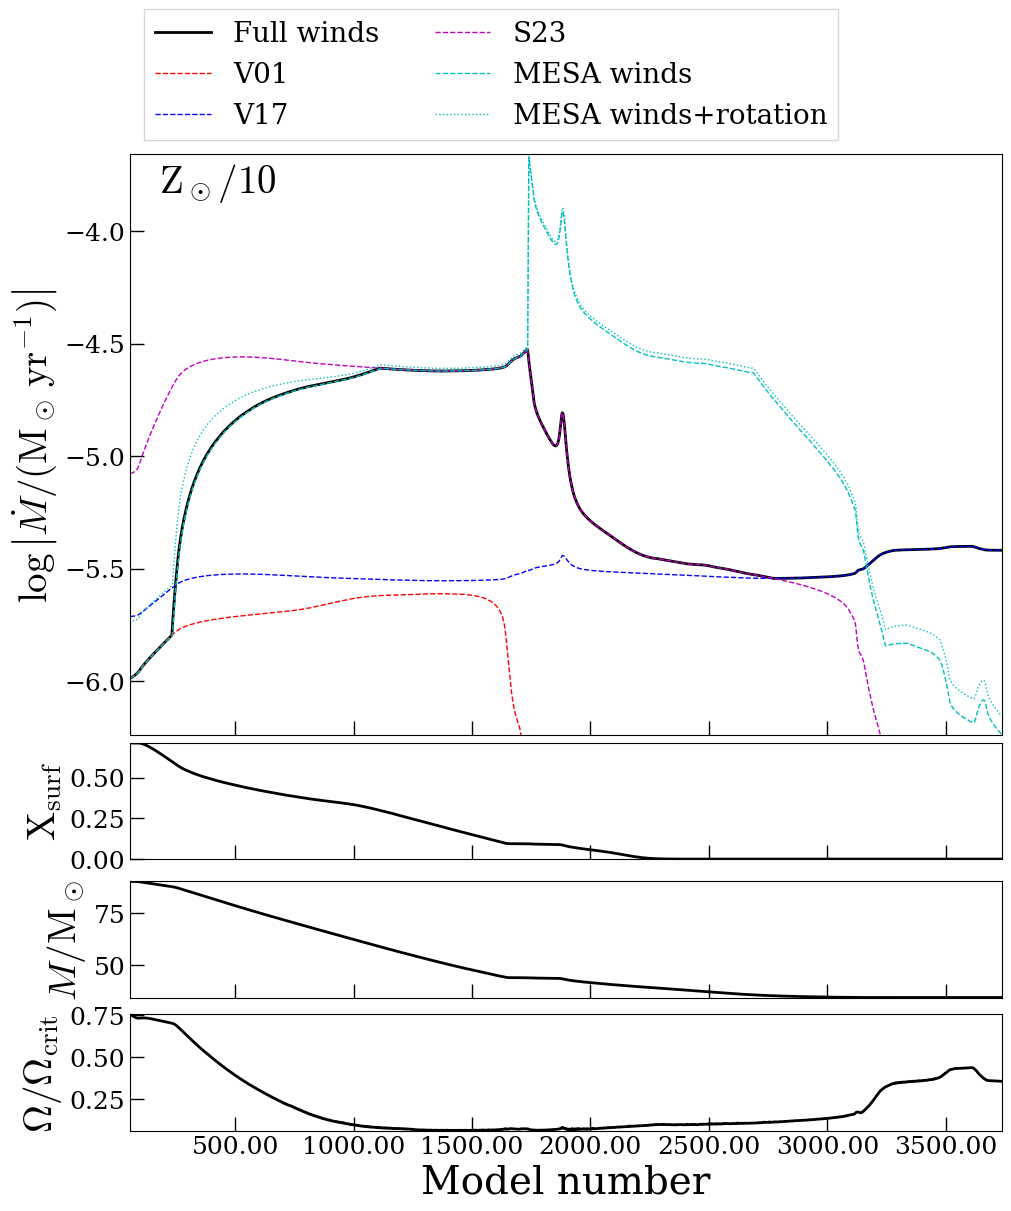

In [70]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_model_n
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
#ax0.plot(x, np.log10(k24_winds), 'g--', label='K24', lw=1)
#ax0.plot(x, np.log10(b23_winds), 'r--', label='B23', lw=1)
ax0.plot(x, np.log10(v01_winds), 'r--', label='V01', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='V17', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='S23', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('Model number')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'windiag_m40_p060_zsun_div_10')